# SKYTRAX British Airways Customer Reviews Sentiment Analysis

---

## Web scraping and analysis

We will use a package called `BeautifulSoup` to collect the data from the web.

### Scraping data from Skytrax

For this task, we are only interested in reviews related to British Airways and the Airline itself.

The data has been collected from: [https://www.airlinequality.com/airline-reviews/british-airways] using `Python` and `BeautifulSoup`.

In [35]:
# Importing all necessary libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import re
from collections import Counter

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [3]:
# Creating a dataframe containing the reviews
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | We chose Rotterdam and Lond...
1,✅ Trip Verified | The entire booking and ticke...
2,Not Verified | British Airways cancelled my ...
3,Not Verified | I wanted to write this review s...
4,✅ Trip Verified | Check in fast and friendly....


In [4]:
# df.to_csv("data/BA_reviews.csv")

The dataset is ready. The loops above collected 1000 reviews by iterating through the paginated pages on the website.

Next we will clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [5]:
df['reviews'][0]

'✅ Trip Verified |  We chose Rotterdam and London City airport because of convenience, both small and having a hotel in the Docklands meant a short distance from City Airport. Three hours before our departure our flight was canceled however. Disappointing, but we made a swift move to Amsterdam Schiphol Airport, but unfortunately we were offered a flight to Heathrow, which meant almost 1,5 hours by tube to our hotel. Flight back operated out of LCY to RTM, but had a 30 mins delay, so in terms of punctuality BA is not very reliant. The flights were okay, with a snack and a drink. The E190 being far more comfortable with 2-2 seating and more legroom than the A319. Our extra expenses for the cancelled flight were handled promptly and we got all the money for extra transport and food back, so BA did a good job in this respect. But hesitant to book again, though they are the only airline flying between RTM and LCY.'

In [6]:
# Splitting into 2 columns at "|"
df[['verification','review']] = df['reviews'].str.split('|', expand = True)

In [7]:
# Dropping the "Trip Verified" section
df.drop(['reviews','verification'], axis = 1, inplace = True)
df['review'] = df['review'].str.lstrip()

In [8]:
df.head()

,review
0,We chose Rotterdam and London City airport bec...
1,The entire booking and ticketing experience ha...
2,British Airways cancelled my flight less than ...
3,I wanted to write this review so I could give ...
4,Check in fast and friendly. Security a breeze....


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


In [10]:
# Downloading all necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rishi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rishi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rishi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [11]:
# Defining a function to clean each review:
def review_cleaner(review):
    # Convert the review to lowercase
    review = review.lower()
    
    # Removing special characters
    review = re.sub(r'\W+', ' ', review)
    
    # Tokenize
    review_tokens = word_tokenize(review)
    
    # Removing stopwords
    clean_tokens = [word for word in review_tokens if word not in stopwords.words('english')]
    
    return ' '.join(clean_tokens)

In [12]:
# Defining a function to analyze sentiments
def sentiment_analyzer(review):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(review)
    return sentiment

In [13]:
# Applying the cleaning function
df['cleaned_review'] = df['review'].apply(review_cleaner)
# Applying the sentiment analysis function to the review column
df['sentiment'] = df['cleaned_review'].apply(sentiment_analyzer)

In [14]:
df['sentiment'][0]

{'neg': 0.123, 'neu': 0.726, 'pos': 0.15, 'compound': 0.3818}

In [16]:
# Extract each sentiment component
df['negative'] = df['sentiment'].apply(lambda x: x['neg'])
df['neutral'] = df['sentiment'].apply(lambda x: x['neu'])
df['positive'] = df['sentiment'].apply(lambda x: x['pos'])
df['compound'] = df['sentiment'].apply(lambda x: x['compound'])

df['sentiment_type'] = df['compound'].apply(lambda score: 'positive' if score > 0.05 else ('negative' if score < -0.05 else 'neutral'))

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review          1000 non-null   object 
 1   cleaned_review  1000 non-null   object 
 2   sentiment       1000 non-null   object 
 3   negative        1000 non-null   float64
 4   neutral         1000 non-null   float64
 5   positive        1000 non-null   float64
 6   compound        1000 non-null   float64
 7   sentiment_type  1000 non-null   object 
dtypes: float64(4), object(4)
memory usage: 62.6+ KB


In [18]:
df.head()

,review,cleaned_review,sentiment,negative,neutral,positive,compound,sentiment_type
0,We chose Rotterdam and London City airport bec...,chose rotterdam london city airport convenienc...,"{'neg': 0.123, 'neu': 0.726, 'pos': 0.15, 'com...",0.123,0.726,0.150,0.3818,positive
1,The entire booking and ticketing experience ha...,entire booking ticketing experience stressful ...,"{'neg': 0.227, 'neu': 0.773, 'pos': 0.0, 'comp...",0.227,0.773,0.000,-0.9595,negative
2,British Airways cancelled my flight less than ...,british airways cancelled flight less 24 hours...,"{'neg': 0.26, 'neu': 0.601, 'pos': 0.14, 'comp...",0.260,0.601,0.140,-0.7650,negative
3,I wanted to write this review so I could give ...,wanted write review could give huge thank one ...,"{'neg': 0.0, 'neu': 0.711, 'pos': 0.289, 'comp...",0.000,0.711,0.289,0.9637,positive
4,Check in fast and friendly. Security a breeze....,check fast friendly security breeze lounge bus...,"{'neg': 0.069, 'neu': 0.498, 'pos': 0.433, 'co...",0.069,0.498,0.433,0.9686,positive


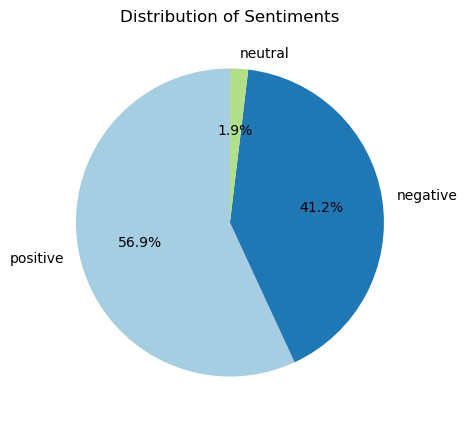

In [21]:
# Plotting a Pie Chart for the sentiment_type
# Calculate the counts of each category
sentiment_counts = df['sentiment_type'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(5,5))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired(np.arange(len(sentiment_counts))))
plt.title('Distribution of Sentiments')
plt.show()

From the Customer Reviews, we can observe that:

- Most of the customers shared POSITIVE REVIEWS.
- Even though the percentage of POSITIVE REVIEWS are higher than the percentage of NEGATIVE REVIEWS, the percentage of NEGATIVE REVIEWS is still very high!!

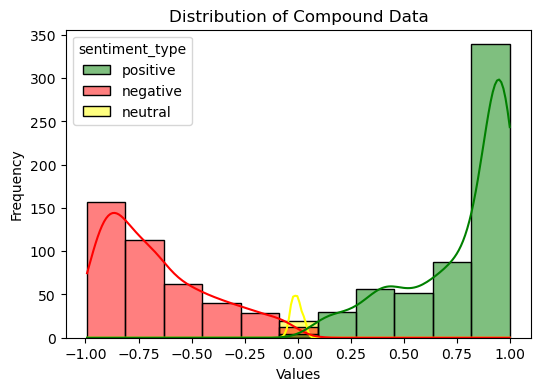

In [33]:
# Plotting a histogram to understand it better
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='compound', hue='sentiment_type',palette=['green', 'red', 'yellow'], kde=True)  # KDE adds a density curve
plt.title('Distribution of Compound Data')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

In [38]:
# We will now try and observe the key words in all the review and plot their occurence to assess their importance
# Combining all the review strings to a single string
review_string = ' '.join(df['cleaned_review'])
# Converting string to list of words
words = review_string.split(' ')
# Counting the frequency of each word
word_counts = Counter(words)

In [40]:
most_common_words = word_counts.most_common(10)

In [41]:
most_common_words

[('flight', 1929),
 ('ba', 1259),
 ('service', 722),
 ('london', 530),
 ('time', 530),
 ('seat', 450),
 ('crew', 448),
 ('class', 446),
 ('food', 437),
 ('good', 429)]

In [42]:
words, counts = zip(*most_common_words)

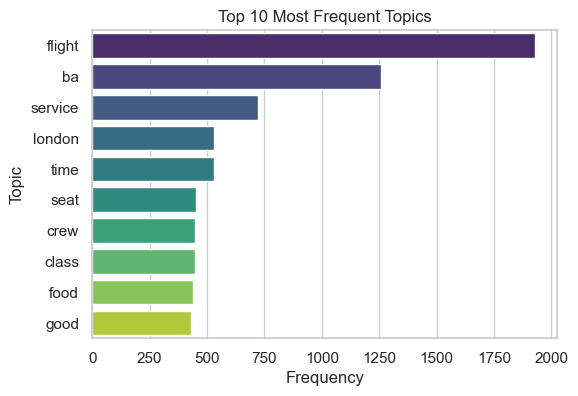

In [45]:
# Setting up the plot with Seaborn styling
sns.set(style="whitegrid")

# Creating the bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=list(counts), y=list(words), palette="viridis")

# Adding title and labels
plt.title('Top 10 Most Frequent Topics')
plt.xlabel('Frequency')
plt.ylabel('Topic')
plt.show()

We can observe the top 10 most frequent words from the sentiment analysis carried out above. The key topics of discussion involves **service**, **seat**, **crew** and **food**.
